RiskParity with Major ETFs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from scipy.optimize import minimize
import seaborn as sns
import statsmodels.formula.api as smf
import yfinance as yf

In [2]:
# https://numpy.org/devdocs/reference/generated/numpy.set_printoptions.html
np.set_printoptions(precision=4, legacy='1.25')
pd.options.display.float_format = '{:.4f}'.format

***Task:***
Propose and backtest your own risk-parity exchange traded fund (ETF) using the tools in this class.
Create a *short* summary of your ETF's approach and performance, using AQR Capital [Multi-Asset Fund (AQRIX)](https://funds.aqr.com/funds/multi-asset/aqr-multi-asset-fund/aqrix#characteristics) as a model.
Compare your performance to:

1. AQRIX
2. 60/40 stock/bond portfolio rebalanced monthly (use SPY for stocks and IEF for bonds)

In [3]:
df = pd.read_excel('/Users/sumitttt/Downloads/DATAproject.xls', usecols="A:E", index_col=0,header=1,parse_dates=True)
df_returns = df.pct_change().dropna()
df_returns

,Japan,India,China,Hong
Date,,,,
2012-02-06,-0.0031,-0.0079,-0.0139,-0.0058
2012-02-07,0.0104,-0.0091,-0.0002,-0.0018
2012-02-08,0.0041,0.0110,0.0223,0.0152
2012-02-09,-0.0031,-0.0026,-0.0009,0.0006
2012-02-10,-0.0123,-0.0181,-0.0320,-0.0092
...,...,...,...,...
2024-10-14,0.0017,0.0023,-0.0201,-0.0138
2024-10-15,-0.0205,-0.0056,-0.0492,-0.0371
2024-10-16,0.0060,0.0009,0.0135,0.0106


In [4]:
def calc_rc(w, Sigma):
    return (w * (Sigma @ w)) / (w.T @ Sigma @ w)

In [5]:
def f(w, Sigma):
    ratio = (w.T @ Sigma @ w) / ((Sigma @ w) * w.shape[0])
    return ((w - ratio)**2).sum()

In [6]:
Sigma = df_returns[['Japan', 'India', 'China', 'Hong']].cov()
w = np.ones(Sigma.shape[0]) / Sigma.shape[0]

result_rp = minimize(
    fun=f,
    x0=w,
    args=(Sigma,),
    bounds=((0,1) for i in w),
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}
    )
)
result_rp['x']

array([0.3106, 0.2398, 0.1907, 0.2589])

In [7]:
calc_rc(result_rp['x'], Sigma)

Japan   0.2501
India   0.2500
China   0.2499
Hong    0.2500
dtype: float64

In [8]:
df_returns = (
    df_returns.assign(
        RP=lambda x: x[['Japan', 'India', 'China', 'Hong']].dot(result_rp['x']))
)

In [9]:
mean_returns = df_returns['RP'].mean()* 252

volatility = df_returns['RP'].std() * np.sqrt(252)

cumulative_returns = (1 + df_returns['RP']).cumprod()
final_cumulative_return = cumulative_returns.iloc[-1]
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

print(f"Cumulative Returns: {final_cumulative_return:.2%}")
print(f"Mean Returns: {mean_returns:.2%}")
print(f"Volatility: {volatility:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Cumulative Returns: 208.19%
Mean Returns: 7.22%
Volatility: 16.95%
Maximum Drawdown: -32.26%


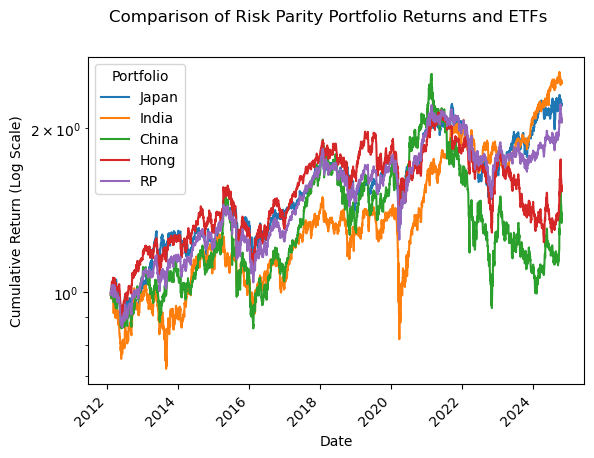

In [10]:
(
    df_returns
    [['Japan', 'India', 'China', 'Hong','RP']]
    .rename_axis(columns='Portfolio')
    .add(1)
    .cumprod()
    .plot(logy=True)
)

plt.ylabel('Cumulative Return (Log Scale)')
plt.suptitle('Comparison of Risk Parity Portfolio Returns and ETFs')
plt.xticks(rotation=45)
plt.show()

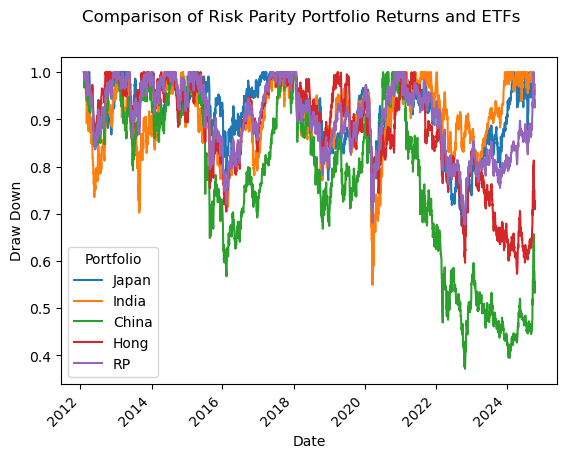

In [11]:
cumprod = df_returns[['Japan', 'India', 'China', 'Hong','RP']].add(1).cumprod()
(
    cumprod
    .rename_axis(columns='Portfolio')
    .div(cumprod.cummax())
    .plot()
)

plt.ylabel('Draw Down')
plt.suptitle('Comparison of Risk Parity Portfolio Returns and ETFs')
plt.xticks(rotation=45)
plt.show()

In [12]:
tickers = ['AQRIX']
df = (
    yf.download(tickers=tickers)
    [['Adj Close']]
    .pct_change()
    .dropna()
    .rename(columns={'Adj Close':'AQRIX'})
)
df.index = df.index.tz_localize(None)

df = (
    df.join(
    pdr.DataReader(
            data_source='famafrench',
            name='F-F_Research_Data_Factors_daily',
            start='1900'
        )[0].div(100),
        how='inner'
    )
    .rename_axis(columns='Ticker')
)


[*********************100%***********************]  1 of 1 completed
/var/folders/91/z4s2gqcn2017kmxtz290cnkw0000gn/T/ipykernel_9872/3049641893.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


In [13]:
mean_returns = df['AQRIX'].mean()* 252

volatility = df['AQRIX'].std() * np.sqrt(252)

risk_free_rate = df['RF'].mean()

cumulative_returns = (1 + df['AQRIX']).cumprod()
final_cumulative_return = cumulative_returns.iloc[-1]
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()


print(f"Cumulative Returns: {final_cumulative_return:.2%}")
print(f"Mean Returns: {mean_returns:.2%}")
print(f"Volatility: {volatility:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Cumulative Returns: 235.44%
Mean Returns: 6.52%
Volatility: 8.51%
Maximum Drawdown: -17.66%


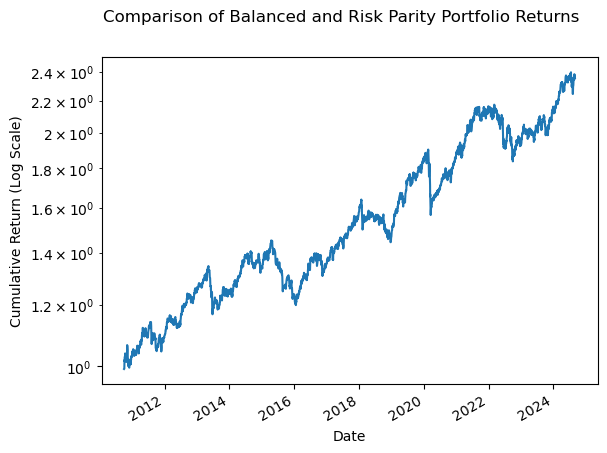

In [14]:
(
    df
    ['AQRIX']
   
    .add(1)
    .cumprod()
    .plot(logy=True)
)

plt.ylabel('Cumulative Return (Log Scale)')
plt.suptitle('Comparison of Balanced and Risk Parity Portfolio Returns')
plt.show()

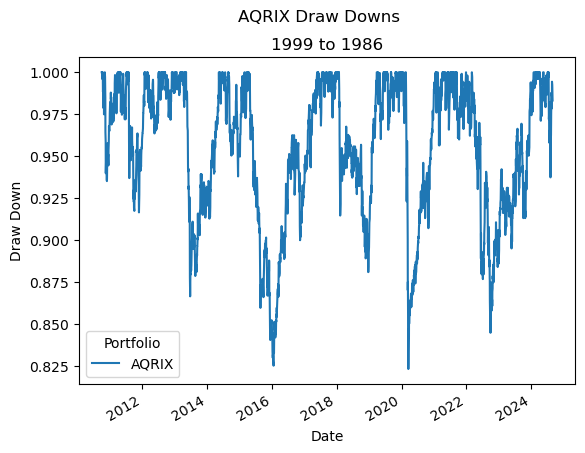

In [15]:
cumprod = df[['AQRIX']].add(1).cumprod()
(
    cumprod
    .rename_axis(columns='Portfolio')
    .div(cumprod.cummax())
    .plot()
)

plt.ylabel('Draw Down')
plt.suptitle('AQRIX Draw Downs')
plt.title(f'{2010-10-1} to {2024-8-30}')
plt.show()

In [16]:
df_returns = df_returns.join(df[['AQRIX']], how='inner')
df_returns

,Japan,India,China,Hong,RP,AQRIX
Date,,,,,,
2012-02-06,-0.0031,-0.0079,-0.0139,-0.0058,-0.0070,-0.0009
2012-02-07,0.0104,-0.0091,-0.0002,-0.0018,0.0006,-0.0018
2012-02-08,0.0041,0.0110,0.0223,0.0152,0.0121,-0.0027
2012-02-09,-0.0031,-0.0026,-0.0009,0.0006,-0.0016,-0.0018
2012-02-10,-0.0123,-0.0181,-0.0320,-0.0092,-0.0167,-0.0027
...,...,...,...,...,...,...
2024-08-26,-0.0125,0.0019,-0.0193,0.0069,-0.0053,-0.0019
2024-08-27,0.0099,-0.0003,0.0038,0.0069,0.0055,-0.0019
2024-08-28,-0.0043,-0.0003,-0.0189,-0.0093,-0.0074,-0.0057


**Comparing Risk parity portfolio to AQRIX**

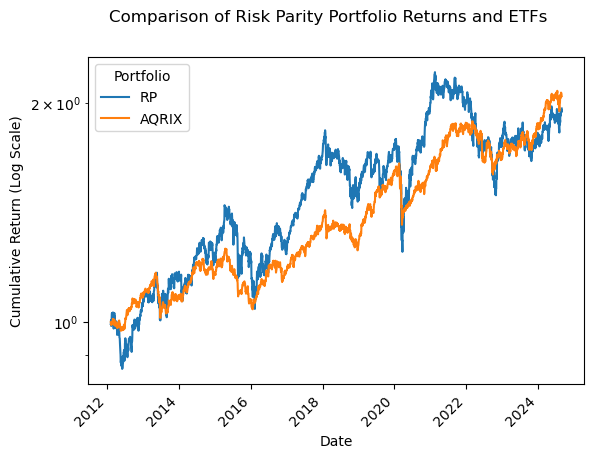

In [17]:


(
    df_returns
    [['RP','AQRIX']]
    .rename_axis(columns='Portfolio')
    .add(1)
    .cumprod()
    .plot(logy=True)
)

plt.ylabel('Cumulative Return (Log Scale)')
plt.suptitle('Comparison of Risk Parity Portfolio Returns and ETFs')
plt.xticks(rotation=45)
plt.show()

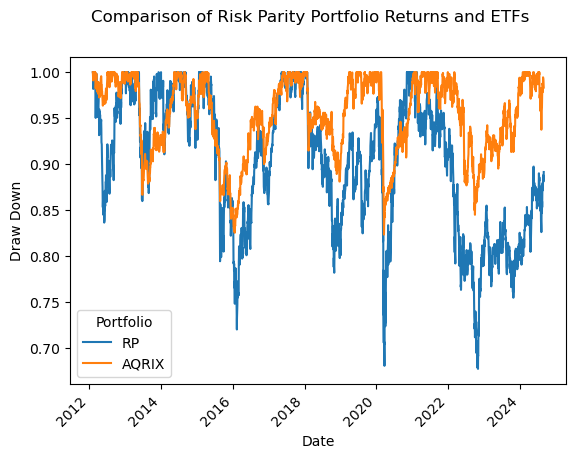

In [18]:
cumprod = df_returns[['RP','AQRIX']].add(1).cumprod()
(
    cumprod
    .rename_axis(columns='Portfolio')
    .div(cumprod.cummax())
    .plot()
)

plt.ylabel('Draw Down')
plt.suptitle('Comparison of Risk Parity Portfolio Returns and ETFs')
plt.xticks(rotation=45)
plt.show()

**Cumulative Return Plot (Log Scale):**

This plot shows the cumulative returns of the RP portfolio and AQRIX ETF over time. Both portfolios experience significant growth, with the RP portfolio showing higher returns overall. The RP portfolio seems more volatile compared to AQRIX but tends to recover and exceed it during periods of upward movement.

**Drawdown Plot:**

This plot illustrates the drawdowns for the RP portfolio and AQRIX ETF. A drawdown represents the decline from a peak to a trough, showing the percentage drop from the highest point. The RP portfolio has deeper drawdowns compared to AQRIX, indicating that it experiences more significant temporary losses during downturns. However, both portfolios follow similar patterns of recovery over time.
Summary:
The RP portfolio outperforms AQRIX in terms of cumulative returns, although it exhibits higher volatility and deeper drawdowns. AQRIX appears more stable but delivers lower long-term returns compared to the RP portfolio. These results suggest that the RP portfolio may offer higher returns with higher associated risk (volatility and drawdowns), while AQRIX provides a more conservative return profile with smaller drawdowns.

In [19]:
tickers = ['SPY', 'IEF']
targets = np.array([0.6, 0.4])

returns = (
    yf.download(tickers=tickers)
    ['Adj Close']
    [tickers]
    .pct_change()
    .loc['2010-10-01':'2024-8-30']
    .rename_axis(columns='Ticker').dropna()
)
returns.index = returns.index.tz_localize(None)
returns

[*********************100%***********************]  2 of 2 completed


Ticker,SPY,IEF
Date,,
2010-10-01,0.0042,0.0005
2010-10-04,-0.0075,0.0035
2010-10-05,0.0201,0.0002
2010-10-06,-0.0001,0.0065
2010-10-07,-0.0012,0.0010
...,...,...
2024-08-26,-0.0024,-0.0012
2024-08-27,0.0014,-0.0004
2024-08-28,-0.0058,-0.0005


In [20]:
rebalance_freq = 'ME' 
values = (
    returns.
    groupby(
        by=pd.Grouper(freq=rebalance_freq),
        group_keys=False
    )
    .apply(lambda x: x.add(1).cumprod().shift().fillna(1) * targets)
)

In [21]:
weights = values.div(values.sum(axis=1), axis=0) 
weights

Ticker,SPY,IEF
Date,,
2010-10-01,0.6000,0.4000
2010-10-04,0.6009,0.3991
2010-10-05,0.5982,0.4018
2010-10-06,0.6030,0.3970
2010-10-07,0.6014,0.3986
...,...,...
2024-08-26,0.5999,0.4001
2024-08-27,0.5996,0.4004
2024-08-28,0.6000,0.4000


In [22]:
rp_d_m = returns.mul(weights).sum(axis=1)
rp_d_m_df = pd.DataFrame(rp_d_m, columns=['60/40'])
rp_d_m_df

,60/40
Date,
2010-10-01,0.0027
2010-10-04,-0.0031
2010-10-05,0.0121
2010-10-06,0.0025
2010-10-07,-0.0003
...,...
2024-08-26,-0.0019
2024-08-27,0.0007
2024-08-28,-0.0037


In [23]:
mean_returns = rp_d_m.mean() * 252 

volatility = rp_d_m.std() * np.sqrt(252)

cumulative_returns = (1 + rp_d_m).cumprod()
final_cumulative_return = cumulative_returns.iloc[-1]
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

print(f"Cumulative Returns: {final_cumulative_return:.2%}")
print(f"Mean Returns: {mean_returns:.2%}")
print(f"Volatility: {volatility:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Cumulative Returns: 351.66%
Mean Returns: 9.52%
Volatility: 9.72%
Maximum Drawdown: -21.28%


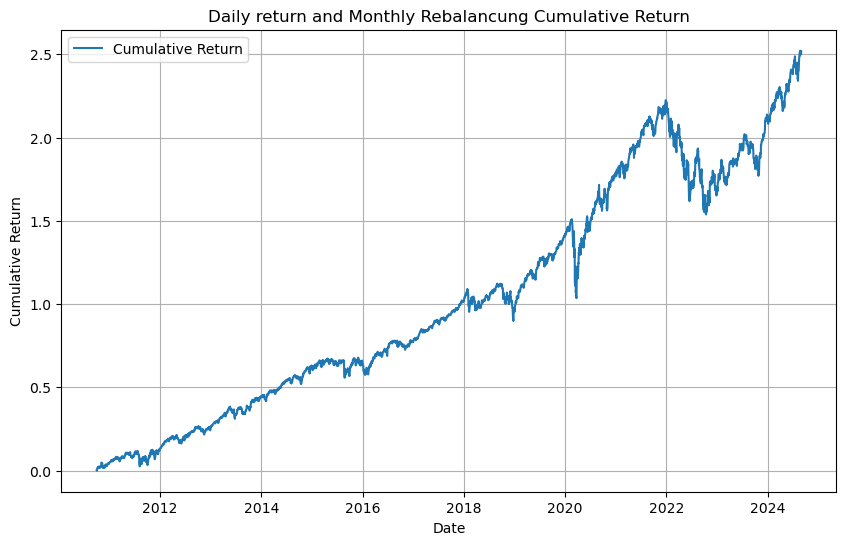

In [24]:
cumulative_return = (1 + rp_d_m).cumprod() - 1
plt.figure(figsize=(10, 6))
plt.plot(cumulative_return, label='Cumulative Return')
plt.title('Daily return and Monthly Rebalancung Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

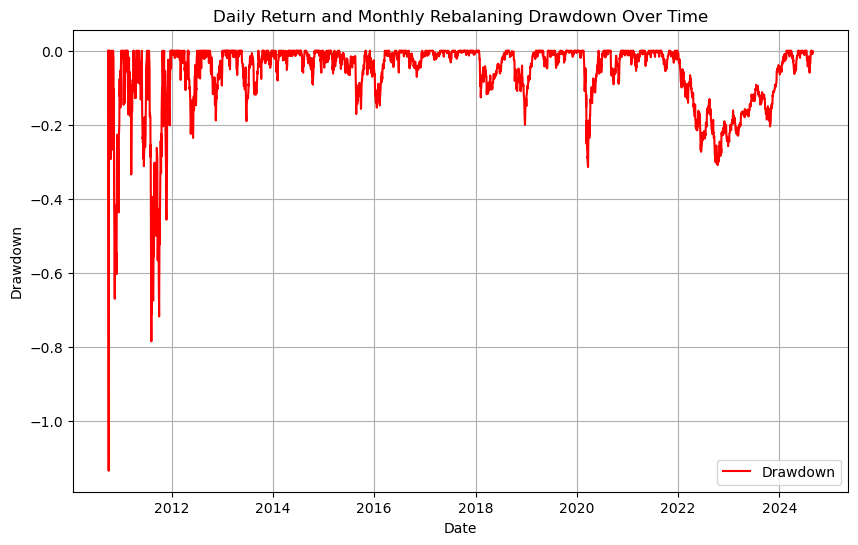

In [25]:
rolling_max = cumulative_return.cummax()
drawdown = (cumulative_return - rolling_max) / rolling_max

plt.figure(figsize=(10, 6))
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Daily Return and Monthly Rebalaning Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

**Comparing Risk parity portfolio to 60/40 rebalanced**

In [26]:
df_returns = df_returns.join(rp_d_m_df[['60/40']], how='inner')
df_returns

,Japan,India,China,Hong,RP,AQRIX,60/40
Date,,,,,,,
2012-02-06,-0.0031,-0.0079,-0.0139,-0.0058,-0.0070,-0.0009,0.0007
2012-02-07,0.0104,-0.0091,-0.0002,-0.0018,0.0006,-0.0018,-0.0010
2012-02-08,0.0041,0.0110,0.0223,0.0152,0.0121,-0.0027,0.0020
2012-02-09,-0.0031,-0.0026,-0.0009,0.0006,-0.0016,-0.0018,-0.0001
2012-02-10,-0.0123,-0.0181,-0.0320,-0.0092,-0.0167,-0.0027,-0.0023
...,...,...,...,...,...,...,...
2024-08-26,-0.0125,0.0019,-0.0193,0.0069,-0.0053,-0.0019,-0.0019
2024-08-27,0.0099,-0.0003,0.0038,0.0069,0.0055,-0.0019,0.0007
2024-08-28,-0.0043,-0.0003,-0.0189,-0.0093,-0.0074,-0.0057,-0.0037


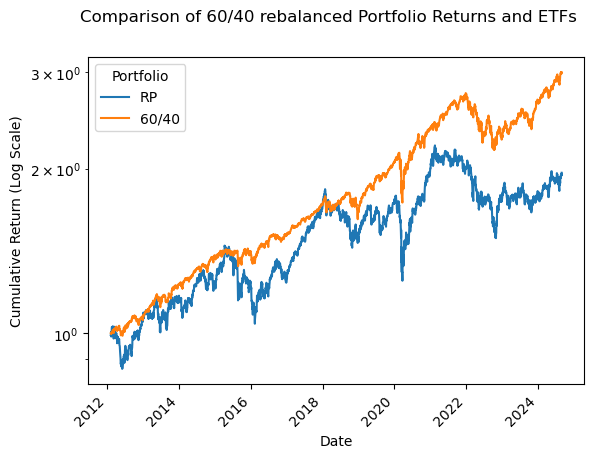

In [27]:
(
    df_returns
    [['RP','60/40']]
    .rename_axis(columns='Portfolio')
    .add(1)
    .cumprod()
    .plot(logy=True)
)

plt.ylabel('Cumulative Return (Log Scale)')
plt.suptitle('Comparison of 60/40 rebalanced Portfolio Returns and ETFs')
plt.xticks(rotation=45)
plt.show()

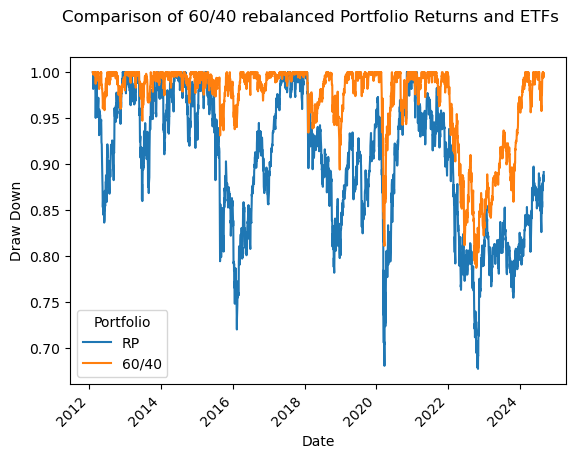

In [28]:
cumprod = df_returns[['RP','60/40']].add(1).cumprod()
(
    cumprod
    .rename_axis(columns='Portfolio')
    .div(cumprod.cummax())
    .plot()
)

plt.ylabel('Draw Down')
plt.suptitle('Comparison of 60/40 rebalanced Portfolio Returns and ETFs')
plt.xticks(rotation=45)
plt.show()

**Cumulative Return Plot (Log Scale):**

The cumulative returns of the 60/40 portfolio (orange) significantly outperform the RP portfolio (blue) over time, especially from 2015 onward. The RP portfolio experiences more volatility and has lower cumulative returns overall compared to the more stable performance of the 60/40 portfolio, which steadily climbs higher.

**Drawdown Plot:**

The RP portfolio suffers deeper and more frequent drawdowns compared to the 60/40 portfolio. The 60/40 portfolio shows much smaller drawdowns, demonstrating greater resilience during downturns. The RP portfolio, on the other hand, appears to recover slower from its drawdowns and exhibits higher risk.
Summary:
The 60/40 rebalanced portfolio outperforms the RP portfolio in terms of cumulative returns and is less volatile, with much smaller drawdowns. The RP portfolio is more susceptible to larger drawdowns and provides lower returns, suggesting higher risk with less reward when compared to the 60/40 portfolio.

**Key Points from the Analysis:**

**Portfolio Construction:**

The portfolio includes allocations to four regions' ETF: Japan, China, India, and Hong Kong. The covariance matrix for these ETFs is calculated based on their returns, and a risk-parity optimization is applied to determine the weights that minimize risk.
**Risk-Parity Portfolio Weights:**

The optimization process generates the weights for the risk-parity (RP) portfolio, which are applied to calculate the cumulative returns for the entire portfolio.
Cumulative Returns (Log Scale): 

**Risk-Parity Portfolio vs. AQRIX:**
Cumulative Returns: The risk-parity portfolio generally performs similarly to AQRIX, but the cumulative return plot shows that AQRIX consistently outperforms the RP portfolio, especially post-2016. AQRIX shows higher returns while the RP portfolio maintains steady but lower growth.

Drawdowns: The RP portfolio experiences larger and more frequent drawdowns than AQRIX. AQRIX has relatively shallower drawdowns, indicating better resilience during market downturns.

**Risk-Parity Portfolio vs. 60/40 Portfolio:**
Cumulative Returns: The 60/40 portfolio outperforms the risk-parity portfolio, especially after 2015. The 60/40 portfolio has a higher upward trajectory, reflecting stronger cumulative returns than the RP portfolio, which shows slower growth.
Drawdowns: The 60/40 portfolio also experiences smaller drawdowns compared to the RP portfolio. This indicates that the 60/40 portfolio is more stable during market declines, while the RP portfolio suffers more significant value drops.

**Key Insights from the Comparison:**
Performance: The RP portfolio, while diversified and constructed to balance risk across Japan, China, India, and Hong Kong, shows slower growth compared to both AQRIX and the 60/40 portfolio. It underperforms these other portfolios in terms of cumulative returns.

**Risk:** 
The RP portfolio has higher drawdowns than both AQRIX and the 60/40 portfolio, which suggests it is more volatile and experiences larger dips in value during market downturns.

**Trade-off:**
The RP portfolio might be more diversified across different international markets, but it does not offer the same level of return or drawdown resilience as the AQRIX or 60/40 portfolios.

**Conclusion:**
The RP portfolio is risk-managed and globally diversified, but when compared to AQRIX and a 60/40 portfolio, it delivers lower returns with higher drawdowns. AQRIX, in particular, demonstrates stronger growth and lower risk exposure, while the 60/40 portfolio provides more stability and consistent returns over time.